# Preparing the Illustris Training Dataset:

In this script we build the Illustris dataset. The code reads in the Illustris-3 simulation snapshot data and produces multilayered DM, gas and internal (thermal) energy arrays for training a GAN. The Illustris dataset is available to the public and can be accessed at: https://www.illustris-project.org/data/downloads/Illustris-3/. To run this script, download the redshift $z=0.0$ snapshot, which takes up 21.8 GB of space, using the following command:

wget -nd -nc -nv -e robots=off -l 1 -r -A hdf5 --content-disposition --header="API-Key: "Add your API-key here"" "http://www.illustris-project.org/api/Illustris-3/files/snapshot-135/?format=api"

Where your API-key has to be added manually. The key is obtained by creating an account at the Illustris website.


In [6]:
from nbodykit.lab import *
from nbodykit import style, setup_logging
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import nbodykit
import os
import illustris_python as il

**Accessing the Illustris snapshot data:**

In [5]:
fields = ['Coordinates']

## Dark matter, gas + internal energy data from snapshot 135 (i.e. z=0.0)
dm_pos = il.snapshot.loadSubset("./data",135,'dm',['Coordinates']); ## Dark matter
gas_pos = il.snapshot.loadSubset("./data",135,'gas',['Coordinates']); ## Gas
energy = il.snapshot.loadSubset("./data",135,'gas',['InternalEnergy']); ## Gas internal Energy


**Plotting a projection of the simulation box:**

Text(0.5, 1.0, 'Gas distribution')

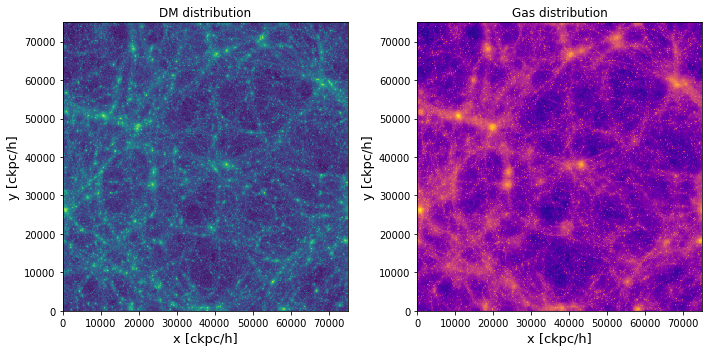

In [21]:
plt.figure(figsize = (10,5.0))
plt.subplot(1, 2, 1)
plt.hist2d(dm_pos[:,0], dm_pos[:,1], norm=mpl.colors.LogNorm(), bins=512);
plt.xlim([0,75000])
plt.ylim([0,75000])
plt.xlabel('x [ckpc/h]', fontsize = 13)
plt.ylabel('y [ckpc/h]', fontsize = 13)
plt.tight_layout()
plt.title('DM distribution')

plt.subplot(1, 2, 2)
plt.hist2d(gas_pos[:,0], gas_pos[:,1], norm=mpl.colors.LogNorm(),cmap='plasma', bins=512);
plt.xlim([0,75000])
plt.ylim([0,75000])
plt.xlabel('x [ckpc/h]',fontsize = 13)
plt.ylabel('y [ckpc/h]',fontsize = 13)
plt.tight_layout()
plt.title('Gas distribution')


**Using Nbodykit to paint the overdensity field:**

The script in the cell below defines 2 catalogues (one for dark matter, one for gas) and uses them to paint the overdensity field. This is done by slicing the simulation box into slices of 100 ckpc/h, defining a grid of size 256x256 and asigning a value equal to the particle overdensity to each cell of the grid.

In [ ]:
## Creating a placeholder catalogue:

cat = RandomCatalog(csize = dm_pos[:,0].size)
cat['Position'] = dm_pos
cat2 = RandomCatalog(csize=gas_pos[:,0].size)
cat2['Position'] = gas_pos
cat2['Energy'] = energy
#cat3 = RandomCatalog(csize=star_pos[:,0].size)
#cat3['Position'] = star_pos


## Arrays to store the outputs:
slices_dm = []
slices_gas = []
slices_gas_energy = []

for i in range(0,2): ## change this limit to 749 for the full dataset
    select = ((cat['Position'][:,0] < (i*100.0 + 100.0)) & (cat['Position'][:,0] > 100.0*i))
    subcat = cat[select]
    mesh = subcat.to_mesh(window='tsc', Nmesh = 256,BoxSize = 75000)
    one_plus_delta = mesh.paint(mode='real')
    samples = one_plus_delta.preview(axes=[1,2])
    slices_dm.append(np.squeeze(samples))

for i in range(0,2):
    select2 = ((cat2['Position'][:,0] < (i*100.0 + 100.0)) & (cat2['Position'][:,0] > 100.0*i))
    subcat2 = cat2[select2]
    mesh2 = subcat2.to_mesh(window='tsc', Nmesh = 256,BoxSize = 75000)
    one_plus_delta2 = mesh2.paint(mode='real')
    samples2 = one_plus_delta2.preview(axes=[1,2])
    slices_gas.append(np.squeeze(samples2))

for i in range(0,2):
    select2 = ((cat2['Position'][:,0] < (i*100.0 + 100.0)) & (cat2['Position'][:,0] > 100.0*i))
    subcat2 = cat2[select2]
    mesh2 = subcat2.to_mesh(window='tsc', Nmesh = 256,BoxSize = 75000, value = "Energy")
    one_plus_delta2 = mesh2.paint(mode='real')
    samples2 = one_plus_delta2.preview(axes=[1,2])
    slices_gas_energy.append(np.squeeze(samples2))



**Transforming the overdensity slices to increase the contrast:**

Here we apply two non-linear transformations to increase the contrast of the images, making the training procedure significantly easier. The transformation can be simply inverted to recover the original images. 

In [27]:
def s(x):
    a = 1000
    return (2*x/(x+a)) - 1

def s2(x):
    a = 2E5
    return (2*x/(x+a)) - 1

slices_dm_tr = []
slices_gas_tr = []
slices_gas_energy_tr = []

for i in slices_dm:
    slices_dm_tr.append(s(i))

for i in slices_gas:
    slices_gas_tr.append(s(i))

for i in slices_gas_energy:
    slices_gas_energy_tr.append(s2(i))

**Plotting some samples:**

Text(0.5, 1.0, 'Gas internal energy')

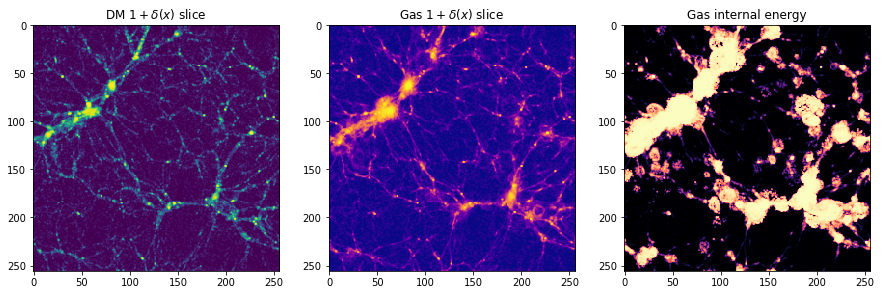

In [33]:
plt.figure(figsize = (15,5.0))
plt.subplot(1,3,1)
plt.imshow(slices_dm_tr[0])
plt.title(r"DM $1+\delta(x)$ slice")
plt.subplot(1,3,2)
plt.imshow(slices_gas_tr[0],cmap="plasma")
plt.title(r"Gas $1+\delta(x)$ slice")
plt.subplot(1,3,3)
plt.imshow(slices_gas_energy_tr[0],cmap="magma")
plt.title(r"Gas internal energy")